In [1]:
# Utility: Preparation text

from contractions import CONTRACTION_MAP

##========== PREPARATION TEXT ===========##

# Contraction
def expand_contractions(sentence, contraction_mapping=CONTRACTION_MAP):
    """
    Expand the contractions in a sentence. For example don't => do not.
    
    Paramters:
    sentence (str): The input sentence to clean.
    contraction_mapping (dict): A dictionary for mapping contractions.
    
    
    Returns:
    str: The expanded contraction sentence.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    
    def expanded_match(contraction):
        """
        Filter for expanding the matched contraction.
        
        Parameters:
        contraction (str): The input of contraction
        
        Returns:
        str: The expanded contraction.
        """
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_sentence = contractions_pattern.sub(expanded_match, sentence)
    return expanded_sentence


def remove_extra_spaces(sentence):
    # Use regex to replace multiple spaces with a single space
    return re.sub(r'\s+', ' ', sentence).strip()


def remove_non_ascii(text):
    """
    Remove all non-ASCII characters from the text.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The cleaned text with only ASCII characters.
    
    """
    
    return ''.join([char for char in text if ord(char) < 128])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from rank_bm25 import BM25Okapi

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy
import gensim

import torch
from sentence_transformers import SentenceTransformer, util

import time
import re
import json


from tqdm import tqdm

**Load Model**

In [3]:
# Load nlp model
nlp = spacy.load('en_core_web_sm')

In [4]:
checkpoint = "sentence-transformers/all-MiniLM-L6-v2"

embedder = SentenceTransformer(checkpoint).to('cuda')

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# Improve efficiency analysis
# 1. Semantic clustering
# 2. PageRank for selecting representation documents

In [6]:
# df = pd.read_csv('sample-mcd.csv', encoding='latin1')
df = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']].iloc[:10_000].copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  10000 non-null  int64 
 1   review_time  10000 non-null  object
 2   review       10000 non-null  object
 3   rating       10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [7]:
# Apply extraction

def process_text(x):
    # Prepare sentence
    texts = expand_contractions(x)
    texts = remove_extra_spaces(x)
    texts = remove_non_ascii(x)
    
    return texts

tqdm.pandas()
df['review_processed'] = df['review'].progress_apply(process_text)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2250.35it/s]


In [21]:
documents = df['review_processed'].values
ids = df['reviewer_id'].values

print(f"Length IDs: {len(ids)}\nLength Documents: {len(documents)}")

Length IDs: 10000
Length Documents: 10000


**Semantic Clustering**

In [9]:
embeddings = embedder.encode(documents, convert_to_tensor=True, device='cuda').cpu().numpy()

# Normalize the embedding to unit length
embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)

print(embeddings.shape)

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


(10000, 384)


C:\Users\Baha Tegar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


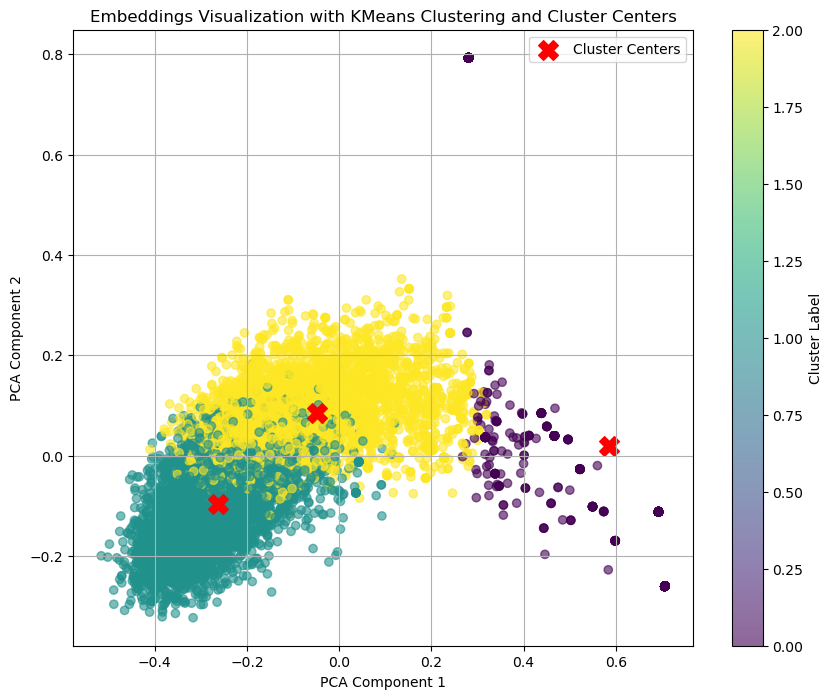

In [10]:
# Clustering with KMeans
n_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Get the cluster centers and reduce their dimensions
cluster_centers = kmeans.cluster_centers_
reduced_centers = pca.transform(cluster_centers)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)

# Adding labels for embeddings
# for i, label in enumerate(cluster_labels):
#     plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

# Plotting the cluster centers
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('Embeddings Visualization with KMeans Clustering and Cluster Centers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.legend()
plt.grid()
plt.show()


In [11]:
torch.cuda.reset_peak_memory_stats()  # Reset peak stats for debugging
torch.cuda.empty_cache()  # Clear cache


In [19]:
len(cluster_labels)

10000

**Selecting Representative Documents Using PageRank**

In [22]:
def bm25_similarity(documents):
    """
    Compute pairwise BM25 similarity between sentences.
    """
    tokenized_documents = [word_tokenize(sentence.lower()) for sentence in documents]
    bm25 = BM25Okapi(tokenized_documents)
    num_documents = len(documents)
    bm25_matrix = np.zeros((num_documents, num_documents))
    

    for i in tqdm(range(len(tokenized_documents)), desc="Calculating BM25 Scores"):
        scores = bm25.get_scores(tokenized_documents[i])
        bm25_matrix[i] = scores

    return bm25_matrix

def cosine_similarity_matrix(documents):
    """
    Compute pairwise cosine similarity between sentences using TF-IDF.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    cosine_matrix = cosine_similarity(tfidf_matrix)
    return cosine_matrix

def hybrid_similarity(documents, alpha=0.5):
    """
    Combine BM25 and cosine similarity matrices with a weighting factor.
    
    Parameters:
    - documents (list of str): List of documents.
    - alpha (float): Weight for BM25 similarity. (1-alpha) is the weight for cosine similarity.
    
    Returns:
    - hybrid_matrix (np.array): Combined similarity matrix.
    """
    bm25_matrix = bm25_similarity(documents)
    cosine_matrix = cosine_similarity_matrix(documents)
    print(f"BM25 {bm25_matrix.shape}\nCOSINE_MATRIX {cosine_matrix.shape}")
    hybrid_matrix = alpha * bm25_matrix + (1 - alpha) * cosine_matrix
    return hybrid_matrix

def pagerank_hybrid_summarization(items, threshold=0.75, min_documents=2, alpha=0.5):
    """
    Summarize text using a hybrid of BM25 and cosine similarity with PageRank.
    
    Parameters:
    - items (str): Tuple of lists (ids,documents).
    - num_sentences (int): Number of sentences in the summary.
    - alpha (float): Weight for BM25 similarity in the hybrid similarity calculation.
    
    Returns:
    - summary (str): Generated summary.
    """

    ids, documents = items
    
    def num_documents(scores):
        scores.sort(reverse=True)
        current_value = 0
        for i in tqdm(range(len(scores)), desc="Optimize Number Documents"):
            current_value += scores[i]
            if current_value > threshold:
                return i
        return
        
    if len(documents) < min_documents:
        return documents  # Return original documents

    print("COMPUTE HYBRID SIMILARITY")
    similarity_matrix = hybrid_similarity(documents, alpha)

    print("APPLY PAGERANK")
    graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(graph)

    print("DETERMINE NUMBER OF DOCUMENTS")
    n = num_documents(list(scores.values()))
      
    print("SELECT TOP N DOCUMENTS")
    ranked_indices = sorted(scores, key=scores.get, reverse=True)[:n]
    ranked_indices = sorted(ranked_indices)
    pagerank_documents = []
    pagerank_ids = []
    for i in tqdm(range(len(ranked_indices)), desc="Sorting Documents"):
        idx = ranked_indices[i]
        pagerank_ids.append(ids[idx])
        pagerank_documents.append(documents[idx])

    # Step 5: Return the summary
    return pagerank_ids, pagerank_documents



# Alternative using compression

# def calculate_optimal_num_sentences(text, compression_ratio=0.2):
#     sentences = sent_tokenize(text)
#     optimal_num_sentences = max(1, int(len(sentences) * compression_ratio))  # Ensure at least 1 sentence
#     return optimal_num_sentences

# n = calculate_optimal_num_sentences(text, compression_ratio=0.75)

In [23]:
rep_per_cluster = {}

for i in np.unique(cluster_labels):
    temp = (ids[np.where(cluster_labels == i)], documents[np.where(cluster_labels == i)])
    print("INITIAL: ", len(temp[-1]))
    start_time = time.time()
    rep_ids, rep = pagerank_hybrid_summarization(temp, alpha=0.7)
    end_time = time.time()
    rep_per_cluster[i] = rep_ids
    print("REPRESENTATION: ", len(rep))

INITIAL:  2101
COMPUTE HYBRID SIMILARITY


Calculating BM25 Scores: 100%|███████████████████████████████████████████████████| 2101/2101 [00:01<00:00, 1094.53it/s]


BM25 (2101, 2101)
COSINE_MATRIX (2101, 2101)
APPLY PAGERANK
DETERMINE NUMBER OF DOCUMENTS


Optimize Number Documents:  73%|█████████████████████████████████▊            | 1544/2101 [00:00<00:00, 1502902.15it/s]


SELECT TOP N DOCUMENTS


Sorting Documents: 100%|███████████████████████████████████████████████████████| 1544/1544 [00:00<00:00, 505779.86it/s]

REPRESENTATION:  1544
INITIAL:  3942
COMPUTE HYBRID SIMILARITY



Calculating BM25 Scores: 100%|█████████████████████████████████████████████████████| 3942/3942 [03:18<00:00, 19.89it/s]


BM25 (3942, 3942)
COSINE_MATRIX (3942, 3942)
APPLY PAGERANK
DETERMINE NUMBER OF DOCUMENTS


Optimize Number Documents:  51%|███████████████████████▌                      | 2024/3942 [00:00<00:00, 1000621.32it/s]


SELECT TOP N DOCUMENTS


Sorting Documents: 100%|███████████████████████████████████████████████████████| 2024/2024 [00:00<00:00, 337357.78it/s]

REPRESENTATION:  2024
INITIAL:  3957
COMPUTE HYBRID SIMILARITY



Calculating BM25 Scores: 100%|█████████████████████████████████████████████████████| 3957/3957 [01:20<00:00, 48.94it/s]


BM25 (3957, 3957)
COSINE_MATRIX (3957, 3957)
APPLY PAGERANK
DETERMINE NUMBER OF DOCUMENTS


Optimize Number Documents:  50%|███████████████████████▋                       | 1997/3957 [00:00<00:00, 998096.41it/s]


SELECT TOP N DOCUMENTS


Sorting Documents: 100%|███████████████████████████████████████████████████████| 1997/1997 [00:00<00:00, 183290.85it/s]

REPRESENTATION:  1997


In [36]:
ids_rep = []
# representation = []

for idss in rep_per_cluster.values():
    # representation += list(rep)
    ids_rep += list(idss)

# representation = documents[ids_rep]

print(len(ids_rep))
# print(len(representation))

5565


In [34]:
mask = [True if id in ids_rep else False for id in df['reviewer_id'].values]

representation = df[mask].to_dict('records')

In [35]:
with open('representation.json', 'w', encoding='utf-8') as f:
    json.dump(representation, f, indent=4)